# cellNexusPy

## Importing the package

In [1]:
from cellnexuspy import get_metadata, get_anndata

## Getting the metadata

The `get_metadata()` function returns a database connection and a DuckDB table.

The table can be used to query the metadata, while the connection's main purpose is to be closed when you are finished:

In [3]:
conn, table = get_metadata()
table

┌──────────────────────────────────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬──────────────────────────────────┬───────────┬────────────────────────────┬──────────────────────────────────┬───────────┬────────────────────────┬────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────┬──────────────────────────────────────┬───────────────────┬─────────────────────────┬────────────────────────────────────┬─────────┬──────────────────────────┬────────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────┬───────────────┬────────────┬──────────┬─────────────────┬─────────────────────┬──────────────┬────────

### Querying the metadata
The DuckDB table can be queried using a number of methods [described here](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyRelation). In particular:
* [`.filter()`](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyRelation.filter): filters the metadata using a string expression
* [`.aggregate()`](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyRelation.aggregate): groups by one or more columns, and calculates some aggregate statistics such as counts
* [`.fetchdf()`](https://duckdb.org/docs/api/python/reference/#duckdb.DuckDBPyRelation.fetchdf): Executes the query and returns it as a pandas DataFrame

In [3]:
table.aggregate("tissue, cell_type_unified_ensemble, COUNT(*) as n", group_expr="tissue, cell_type_unified_ensemble")

┌────────────────────────────────┬────────────────────────────┬────────┐
│             tissue             │ cell_type_unified_ensemble │   n    │
│            varchar             │          varchar           │ int64  │
├────────────────────────────────┼────────────────────────────┼────────┤
│ blood                          │ progenitor                 │  59084 │
│ lung                           │ progenitor                 │  86008 │
│ lung                           │ stromal                    │ 159983 │
│ dorsolateral prefrontal cortex │ cd4 naive                  │     43 │
│ liver                          │ b memory                   │   1440 │
│ liver                          │ b                          │   2818 │
│ bladder organ                  │ cd8 tcm                    │     57 │
│ bladder organ                  │ monocytic                  │     54 │
│ bone marrow                    │ cd4 tcm                    │   6486 │
│ bone marrow                    │ cd4 th17 em     

In [4]:
table.filter("self_reported_ethnicity == 'African'")

┌──────────────────────────────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬──────────────────────────────────┬──────────────────────────────────────────────────────┬────────────────────────────┬──────────────────────────────────┬───────────┬────────────────────────┬────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬─────────────────────────────┬────────────────────────────────────┬─────────┬──────────────────────────┬──────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────┬───────────────┬──────────────┬──────────┬────────────────

# Quality control

cellNexusPy metadata provides quality control records such as empty droplets, inoperable cells (death or damaged), doublets, and samples with low gene counts:

In [4]:
table = table.filter("""
    empty_droplet = 'false'
    AND alive = 'true'
    AND "scDblFinder.class" != 'doublet'
    AND feature_count >= 5000
""")

query = table.filter("""
    self_reported_ethnicity = 'African'
    AND assay LIKE '%10%'
    AND tissue = 'lung parenchyma'
    AND cell_type LIKE '%CD4%'
    AND feature_count >= 5000
""")
query

┌───────────────────────────────────────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬──────────────────────────────────────────────────┬─────────────────────────────────┬────────────────────────────┬──────────────────────────────────┬───────────┬────────────────────────┬────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────┬──────────────────────────────────────┬───────────────────┬─────────────────────────┬────────────────────────────────────┬─────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────┬───────────────┬─────────────────────────────────────────────────────────────────────

## Query raw counts

Once you have filtered your query accordingly, you can pass it into `get_anndata()` to obtain an AnnData object:

In [6]:
adata = get_anndata(query, assay ="counts")
adata

View of AnnData object with n_obs × n_vars = 1780 × 56239
    obs: 'cell_id', 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'run_from_cell_id', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'x_approximate_distribution', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell

## Query counts scaled per million

You can query counts scaled per million. This is helpful if just few genes are of interest:

In [26]:
adata = get_anndata(query, assay = 'cpm')
adata

## Query pseudobulk

cellNexusPy metadata allows to work with pseudobulk data:

In [8]:
get_anndata(query, aggregation = "pseudobulk")

View of AnnData object with n_obs × n_vars = 98 × 56239
    obs: 'dataset_id', 'sample_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'run_from_cell_id', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'x_approximate_distribution', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_type_unified_ensemble', 'sample_chunk', 'cell_chunk', 'sample_pseudobulk_chun

## Query metacell

cellNexusPy metadata provides a series of metacell affrefation levels, starting with 2, 4, 8, and so on. 

For example, `metacel_2` represents group of cells that can be split into two distinct metacells:

In [9]:
get_anndata(query, aggregation = "metacell_2")

View of AnnData object with n_obs × n_vars = 914 × 56239
    obs: 'dataset_id', 'sample_id', 'assay', 'assay_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'is_primary_data', 'organism', 'organism_ontology_term_id', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'age_days', 'tissue_groups', 'atlas_id', 'sample_chunk', 'file_id_cellNexus_single_cell', 'file_id_cellNexus_metacell'

## Extract only a subset of genes

We can query a subset of genes. Notice how the result only has `nvars = 1`:

In [10]:
get_anndata(query, assay = "cpm", features = ['ENSG00000134644'])

View of AnnData object with n_obs × n_vars = 1780 × 1
    obs: 'cell_id', 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'run_from_cell_id', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'x_approximate_distribution', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_ann

# Visualizing gene expression

Taking advantage of the `AnnData` object, we can use `scanpy` library to visualize gene expression gfor a groups of interest:

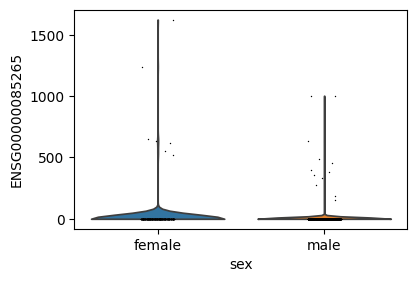

In [28]:
from matplotlib.pyplot import rc_context
import scanpy as sc

with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(adata, ["ENSG00000085265"], groupby="sex")


Furthermore, it is possible to use `matplotlib` to generate customized plots:

/tmp/ipykernel_1965400/1821015775.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr = adata.to_df()[gene].groupby(adata.obs[group]).mean()


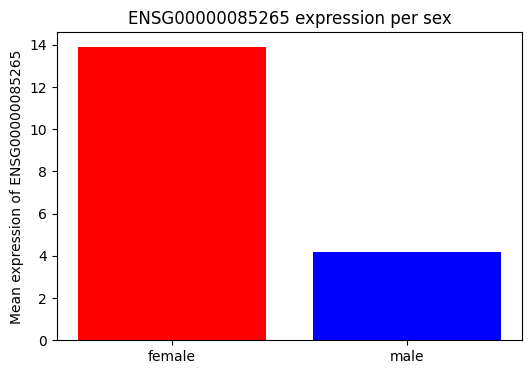

In [28]:
import matplotlib.pyplot as plt

gene = "ENSG00000085265"
group = "sex"

# Compute mean expression per condition
mean_expr = adata.to_df()[gene].groupby(adata.obs[group]).mean()

# Plot
plt.figure(figsize=(6,4))
plt.bar(mean_expr.index, mean_expr.values, color=['red','blue'])
plt.ylabel(f"Mean expression of {gene}")
plt.title(f"{gene} expression per {group}")
plt.show()

# Saving as H5AD 

It is possible to save `AnnData` objects using the function `write_h5ad`:

In [15]:
adata.obs.index.name = None
adata.obs["run_from_cell_id"] = adata.obs["run_from_cell_id"].fillna("NA").astype(str)
adata.obs["suspension_type"] = adata.obs["suspension_type"].fillna("NA").astype(str)
adata.obs["x_approximate_distribution"] = adata.obs["x_approximate_distribution"].fillna("NA").astype(str)

adata.write_h5ad("myH5ADfile.h5ad")

## Finishing Up

When you are finished, you should close the connection:

In [30]:
conn.close()